In [9]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sbi import utils as sbi_utils
from sbi import inference as sbi_inference
from sbi.inference import simulate_for_sbi
from sbi.analysis import plot_summary
import pymc as pm
import arviz as az

In [17]:
def run_experiment(
    theta_true=torch.tensor([3.6, -4.4]), # True parameters (m, c)
    sigma_noise=0.1,                      # Observation noise
    n_grid=20,                            # Number of x-points
    x_domain=(-1.0, 1.0),                 # Range of x-values
    prior_bounds=(-10.0, 10.0),           # Uniform prior bounds
    num_simulations=2000,                 # SBI simulations
    num_posterior_samples=10000,          # Posterior samples
    plot=True                             # Toggle plotting
):
    # Setup environment
    device = torch.device('cpu')
    torch.manual_seed(42)
    x_grid = torch.linspace(x_domain[0], x_domain[1], n_grid).to(device)
    prior_low = torch.tensor([prior_bounds[0]] * 2).to(device)
    prior_high = torch.tensor([prior_bounds[1]] * 2).to(device)
    prior = sbi_utils.BoxUniform(low=prior_low, high=prior_high)
    
    # Simulator
    def simulator(theta, x_grid, sigma_noise):
        m, c = theta[..., 0], theta[..., 1]
        noise = torch.randn_like(x_grid) * sigma_noise
        return m[..., None] * x_grid + c[..., None] + noise

    # Analytic solution fucntion
    def analytic_posterior(x_grid, y_obs, sigma_noise, prior_low, prior_high):
        var_uniform = ((prior_high - prior_low) ** 2) / 12.0
        Sigma0 = torch.diag(var_uniform)
        Sigma0_inv = torch.inverse(Sigma0)
        X_mat = torch.stack([x_grid, torch.ones_like(x_grid)], dim=1)
        Sigma_post_inv = Sigma0_inv + (1.0 / sigma_noise**2) * X_mat.T @ X_mat
        Sigma_post = torch.inverse(Sigma_post_inv)
        mu_post = Sigma_post @ (
            Sigma0_inv @ torch.zeros(2) + (1.0 / sigma_noise**2) * X_mat.T @ y_obs
        )
        return mu_post, Sigma_post
        
    # MCMC function
    def mcmc(x_grid, y_obs, sigma_noise):    
        x_np = x_grid.cpu().numpy()
        y_np = y_obs.cpu().numpy()
        with pm.Model() as model:
            m = pm.Uniform("m", lower=prior_bounds[0], upper=prior_bounds[1])
            c = pm.Uniform("c", lower=prior_bounds[0], upper=prior_bounds[1])
            y_est = m * x_np + c
            y_like = pm.Normal("y_like", mu=y_est, sigma=sigma_noise, observed=y_np)
            trace = pm.sample(2000, tune=1000, chains = 4, cores=2, return_inferencedata=True, progressbar=True)
            mcmc_samples = trace.posterior.stack(samples=("chain", "draw"))
            mcmc_m = mcmc_samples["m"].values.flatten()
            mcmc_c = mcmc_samples["c"].values.flatten()
        
        return torch.tensor(np.vstack([mcmc_m, mcmc_c]).T)
        
    # Generate observed data
    sim_wrapper = lambda theta: simulator(theta, x_grid, sigma_noise)
    with torch.no_grad():
        y_obs = sim_wrapper(theta_true)
    
    # Run SBI
    thetas, xs = simulate_for_sbi(sim_wrapper, prior, num_simulations=num_simulations)
    inference = sbi_inference.SNPE(prior=prior)
    density_estimator = inference.append_simulations(thetas, xs).train()
    posterior = inference.build_posterior(density_estimator)
    posterior_samples = posterior.sample((num_posterior_samples,), x=y_obs)
    
    # Analytic solution
    mu_post, Sigma_post = analytic_posterior(x_grid, y_obs, sigma_noise, prior_low, prior_high)
    analytic_samples = torch.distributions.MultivariateNormal(mu_post, Sigma_post).sample((num_posterior_samples,))
    
    # MCMC
    mcmc_samples = mcmc(x_grid, y_obs, sigma_noise)
    
    # Plotting
    if plot:
        fig, ax = plt.subplots(1, 2, figsize=(14, 7))
        
        # Left plot: Parameter space
        ax[0].scatter(posterior_samples[:, 0], posterior_samples[:, 1], alpha=0.1, label="SBI", color="b")
        ax[0].scatter(analytic_samples[:, 0], analytic_samples[:, 1], alpha=0.1, label="Analytic", color="g")
        if mcmc_samples is not None:
            ax[0].scatter(mcmc_samples[:, 0], mcmc_samples[:, 1], alpha=0.1, label="MCMC", color="r")
        ax[0].scatter([theta_true[0]], [theta_true[1]], marker='x', s=100, label="Truth", color="k")
        ax[0].set_xlabel(r"Slope ($m$)")
        ax[0].set_ylabel(r"Intercept ($c$)")
        ax[0].set_title("Parameter space (Analytic vs MCMC vs SBI)")
        ax[0].legend()
        
        # Right plot: Posterior predictions
        x_dense = torch.linspace(x_domain[0]-0.2, x_domain[1]+0.2, 100)
        m0, c0 = posterior_samples[0]
        ax[1].plot(x_dense, m0 * x_dense + c0, alpha=0.05, label="SBI posterior samples", color="c")
        for i in range(200):
            m, c = posterior_samples[i]
            ax[1].plot(x_dense, m * x_dense + c, alpha=0.05, color="c")
        ax[1].scatter(x_grid, y_obs, label="Observed data", color="m")
        ax[1].plot(x_dense, theta_true[0] * x_dense + theta_true[1], label="Truth", color="k")
        ax[1].set_xlabel(r"$x$")
        ax[1].set_ylabel(r"$y$")
        ax[1].set_title("Possible regression lines from the SBI posterior")
        ax[1].legend()
        
        plt.tight_layout()
        plt.show()

  0%|          | 0/2000 [00:00<?, ?it/s]

 Neural network successfully converged after 229 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [m, c]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 6 seconds.


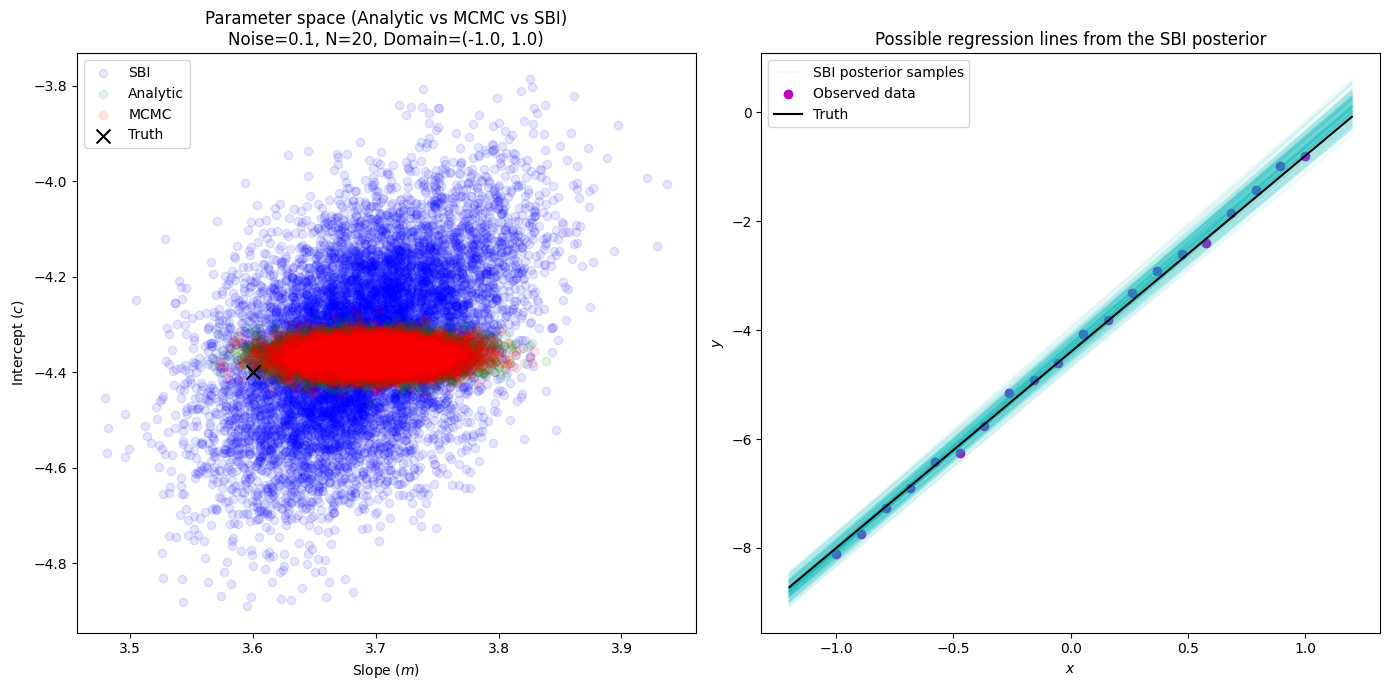

In [15]:
run_experiment()  # Default

  0%|          | 0/2000 [00:00<?, ?it/s]

 Neural network successfully converged after 188 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [m, c]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 6 seconds.


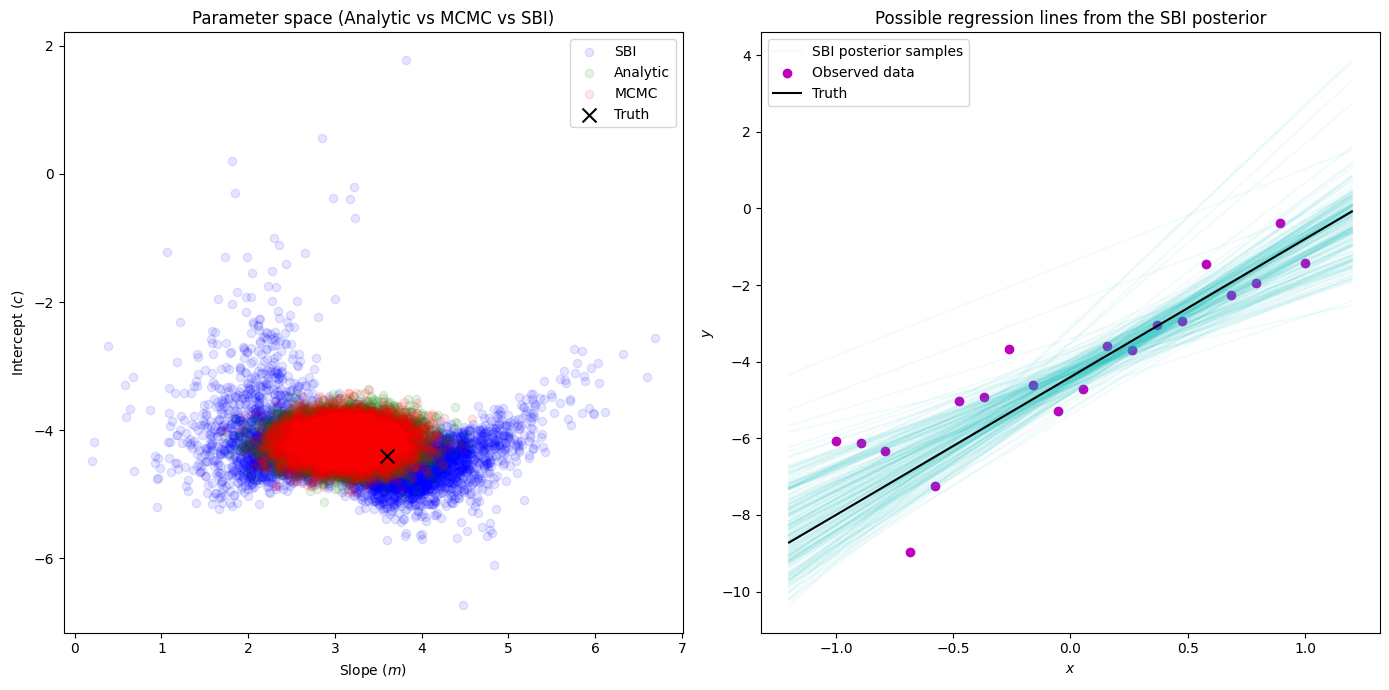

In [18]:
run_experiment(sigma_noise=1.0) # high noise

  0%|          | 0/2000 [00:00<?, ?it/s]

 Neural network successfully converged after 135 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [m, c]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 6 seconds.


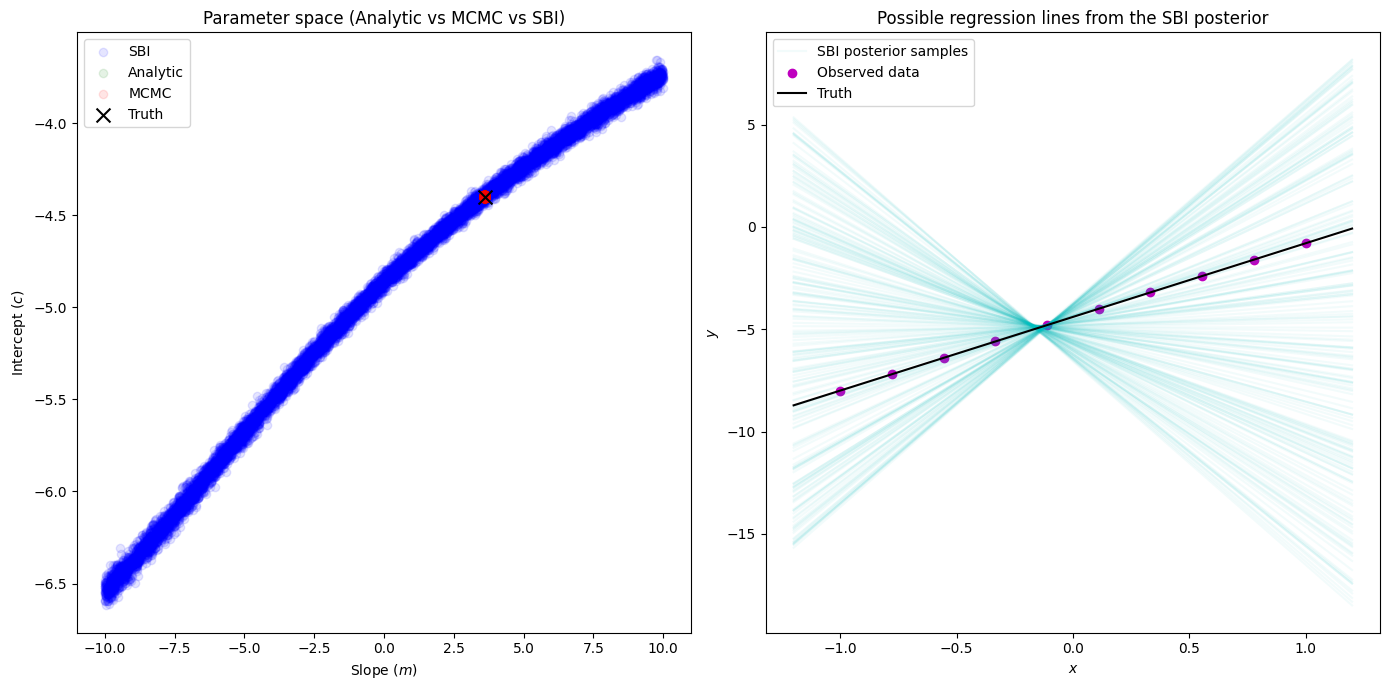

In [19]:
run_experiment(sigma_noise=0.01, n_grid=10) # low noise

  0%|          | 0/2000 [00:00<?, ?it/s]

 Neural network successfully converged after 388 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [m, c]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 6 seconds.


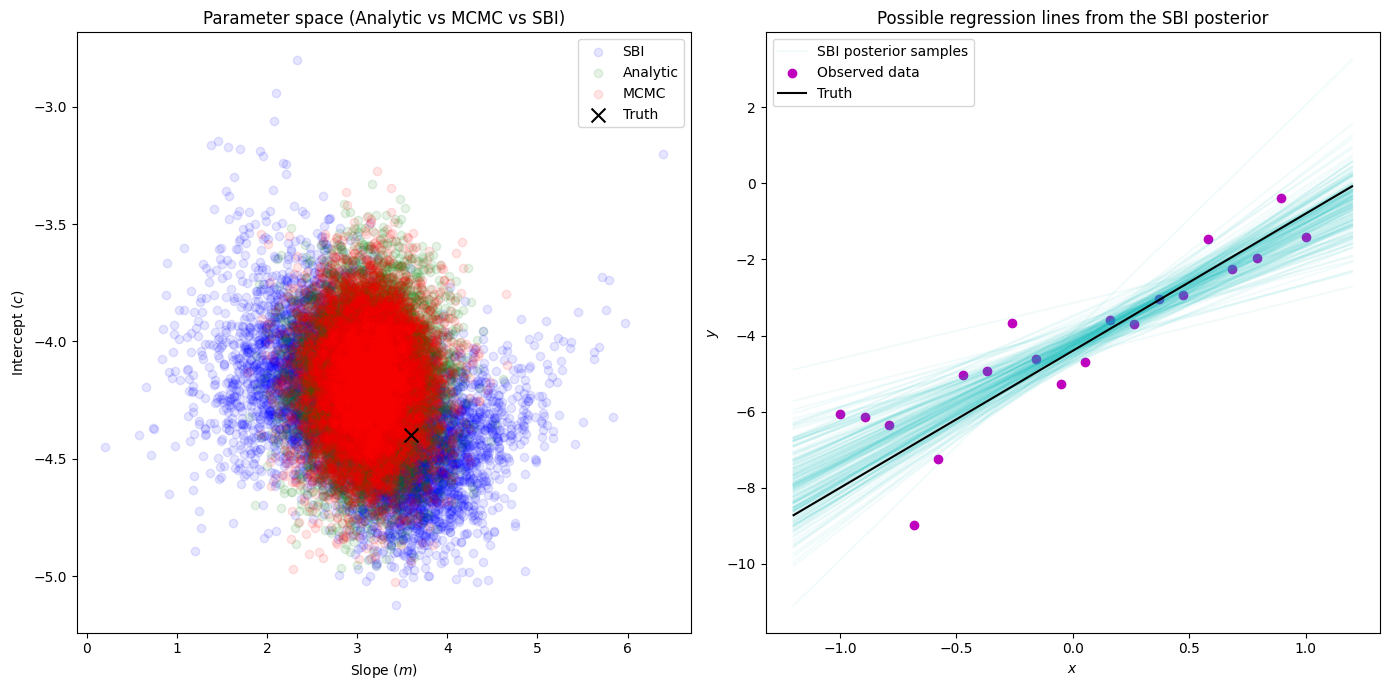

In [20]:
run_experiment(sigma_noise=1.0, prior_bounds=(-20, 20)) # high noise + wide prior

  0%|          | 0/2000 [00:00<?, ?it/s]

 Neural network successfully converged after 270 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [m, c]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 6 seconds.


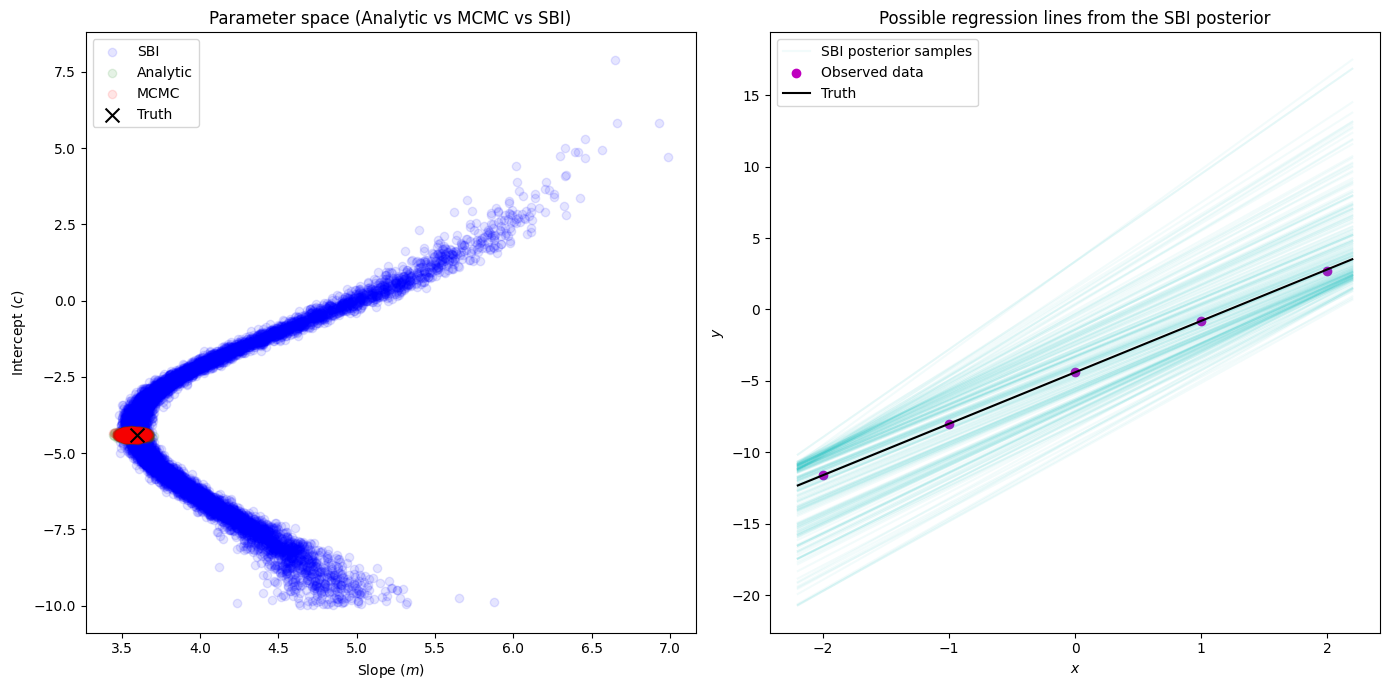

In [21]:
run_experiment(n_grid=5, x_domain=(-2, 2)) # sparse data

  0%|          | 0/2000 [00:00<?, ?it/s]

 Neural network successfully converged after 623 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [m, c]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 6 seconds.


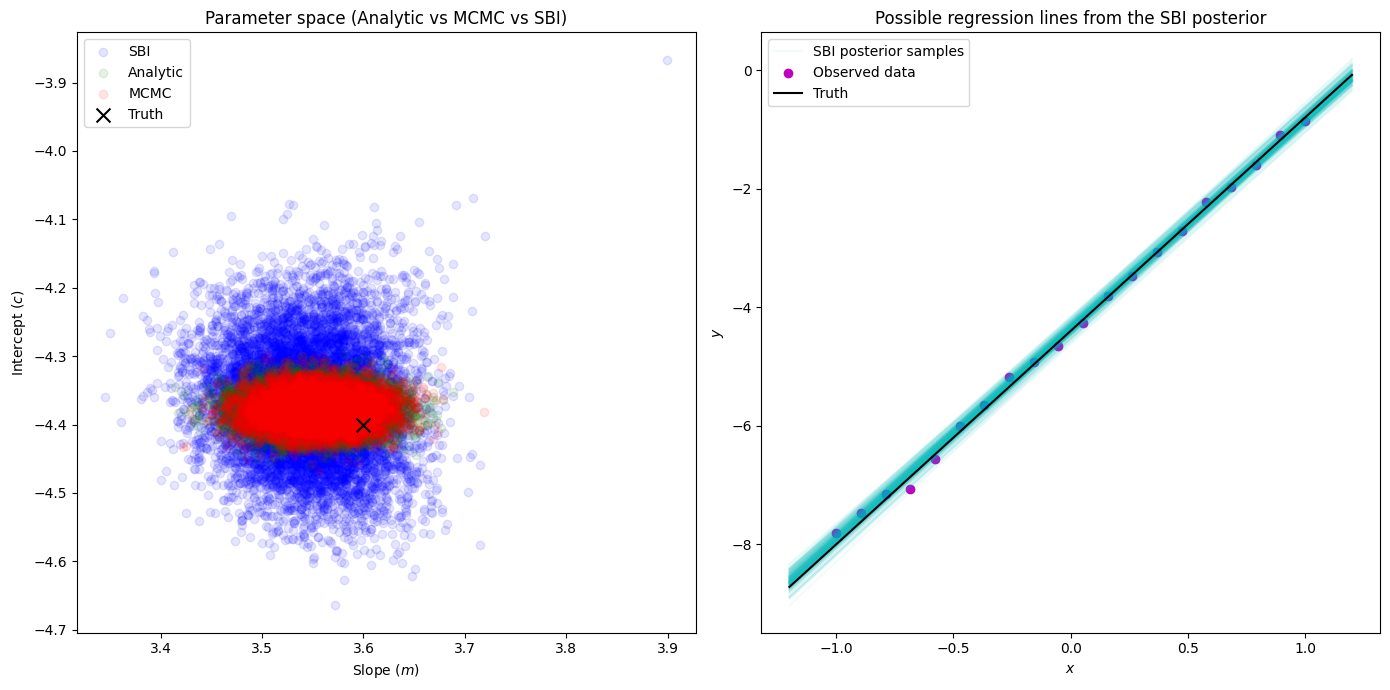

In [23]:
run_experiment(prior_bounds=(-5.0, 6.0)) # narrow, assymetric prior bounds